In [1]:
%load_ext autoreload
%autoreload 2

from collections import OrderedDict
import cv2
import copy
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
from skimage.transform import resize
from skimage.color import rgb2gray

import detectron2.utils.comm as comm
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.config import get_cfg
from detectron2.config import CfgNode as CN
from detectron2.data import (
    MetadataCatalog,
    build_detection_test_loader,
    build_detection_train_loader,
)
from detectron2.engine import DefaultTrainer, DefaultPredictor, default_argument_parser, default_setup, launch
from detectron2.evaluation import inference_on_dataset, COCOEvaluator
from detectron2.modeling import build_model
from detectron2.utils.events import EventStorage
from detectron2.utils.logger import setup_logger
from detectron2.utils.visualizer import Visualizer

import scene_generation.inverse_graphics.synthetic_scene_database_loader as loader
from scene_generation.inverse_graphics.synthetic_scene_database_loader import XenRCNNMapper
import scene_generation.inverse_graphics.keypoint_mcmc.roi_heads as roi_heads

np.set_printoptions(precision=2)

DATA_ROOT = "/home/gizatt/data/generated_cardboard_envs/"
DETECTRON_ROOT = "/home/gizatt/tools/detectron2/"

%matplotlib inline
def cv2_imshow(im):
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
    plt.axis('off')

/home/gizatt/projects/scene_generation/inverse_graphics/synthetic_scene_database_loader.py:24: _DrakeImportWarning: 
You may have already (directly or indirectly) imported `torch` which uses
`RTLD_GLOBAL`. Using `RTLD_GLOBAL` may cause symbol collisions which manifest
themselves in bugs like "free(): invalid pointer". Please consider importing
`pydrake` (and related C++-wrapped libraries like `cv2`, `open3d`, etc.)
*before* importing `torch`. For more details, see:
https://github.com/pytorch/pytorch/issues/3059#issuecomment-534676459

  from scene_generation.utils.type_convert import (


In [2]:
from detectron2.data import DatasetCatalog, MetadataCatalog
from scene_generation.inverse_graphics.synthetic_scene_database_loader import load_xencoco_json

DatasetCatalog.clear()
def load_dataset(d):
    return load_xencoco_json(
        os.path.join(DATA_ROOT, "%s.json" % (d)),
        data_root=DATA_ROOT,
        dataset_name="synthetic_%s" % d)
def load_real_dataset():
    return detectron2.data.datasets.load_coco_json(
        "/home/gizatt/data/coco/cardboard_boxes_in_wild/coco.json",
        image_root="/home/gizatt/data/coco/cardboard_boxes_in_wild/images",
        dataset_name="prime_boxes_real", extra_annotation_keys=None)
for d in ["train", "test"]:
    DatasetCatalog.register("synthetic_" + d, lambda d=d: load_dataset(d))
DatasetCatalog.register("prime_boxes_real", load_real_dataset)
synthetic_train_metadata = MetadataCatalog.get("synthetic_train")
real_prime_boxes_metadata = MetadataCatalog.get("prime_boxes_real")
real_prime_boxes_metadata.set(json_file="/home/gizatt/data/coco/cardboard_boxes_in_wild/coco.json")
print("Metadata train: ", synthetic_train_metadata)
print("Metadata real: ", real_prime_boxes_metadata)
DatasetCatalog.register("synthetic_5_types", lambda: load_dataset("scene_groups_5_types"))

Metadata train:  Metadata(name='synthetic_train')
Metadata real:  Metadata(json_file='/home/gizatt/data/coco/cardboard_boxes_in_wild/coco.json', name='prime_boxes_real')


In [3]:
cfg = get_cfg()
cfg.merge_from_file(os.path.join(DETECTRON_ROOT, "configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))

cfg.INPUT.MIN_SIZE_TRAIN = (480)
cfg.INPUT.MIN_SIZE_TEST = (480)
cfg.INPUT.DEPTH_FORMAT = 'L'
cfg.DATALOADER.ASPECT_RATIO_GROUPING = False

cfg.DATASETS.TRAIN = ("synthetic_train",)
cfg.DATASETS.TEST = ("synthetic_test",)
cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.META_ARCHITECTURE = "GeneralizedRCNN"
cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl"  # initialize from model zoo
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # default
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (prime box)
cfg.MODEL.ROI_HEADS.NAME = "KeypointMCMCROIHeads"
cfg.MODEL.ROI_HEADS.HEATMAP_LOSS_WEIGHT = 1E4

cfg.MODEL.ROI_HEATMAP_HEAD = CN()
cfg.MODEL.ROI_HEATMAP_HEAD.NAME = "RCNNHeatmapHead"
cfg.MODEL.ROI_HEATMAP_HEAD.POOLER_RESOLUTION = 50
cfg.MODEL.ROI_HEATMAP_HEAD.POOLER_SAMPLING_RATIO = 2
cfg.MODEL.ROI_HEATMAP_HEAD.POOLER_TYPE = "ROIAlign"
cfg.MODEL.ROI_HEATMAP_HEAD.NUM_CONV = 5
cfg.MODEL.ROI_HEATMAP_HEAD.CONV_CHANNELS = [3, 3, 3, 1, 2] # Last num channels needs to be the # of keypoint types
cfg.MODEL.ROI_HEATMAP_HEAD.CONV_SIZES = [3, 3, 3, 1, 1]
cfg.MODEL.ROI_HEATMAP_HEAD.NORM = ""


test_loader = build_detection_test_loader(cfg, dataset_name="synthetic_test", mapper=XenRCNNMapper(cfg, True))

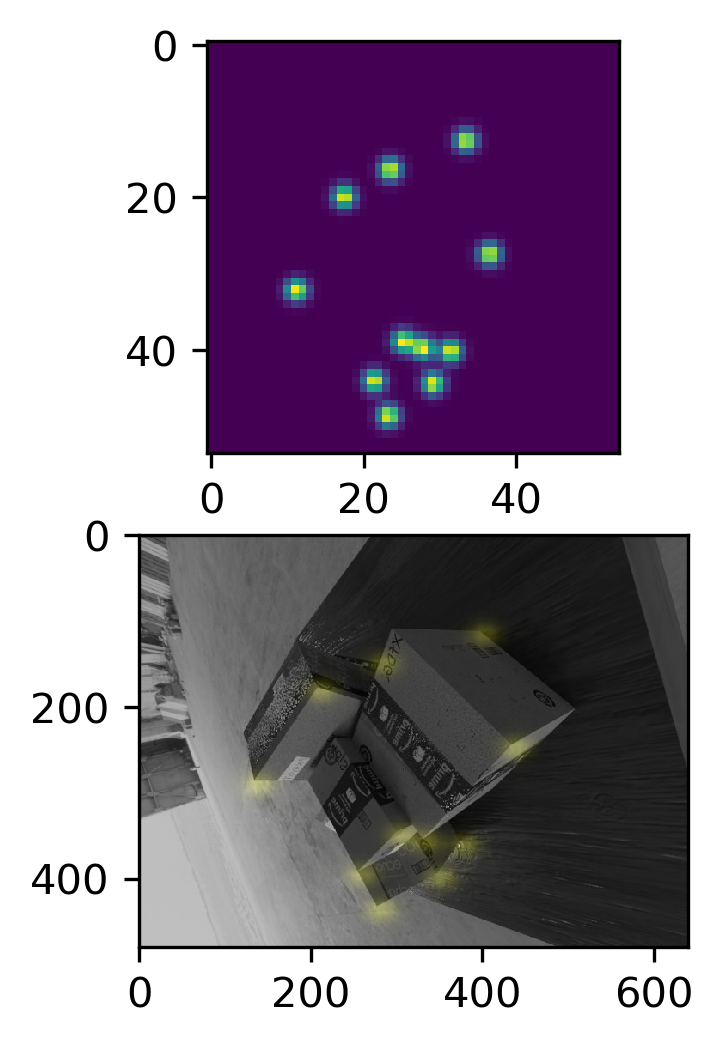

In [4]:
out = iter(test_loader).next()[0]
plt.figure(dpi=300).set_size_inches(4, 4)
orig_image_gray = rgb2gray(out["image"].permute(1, 2, 0).flip(-1))
total_heatmap = sum([out["instances"][k].gt_heatmaps[0, 0, ...] for k in range(len(out["instances"]))])

plt.subplot(2, 1, 1)
plt.imshow(total_heatmap)

total_heatmap = resize(total_heatmap.detach().cpu().numpy(), orig_image_gray.shape)
total_heatmap /= np.max(total_heatmap)

plt.subplot(2, 1, 2)
plt.imshow(np.stack([orig_image_gray*0.75 + total_heatmap*0.25, orig_image_gray*0.75 + total_heatmap*0.25, orig_image_gray*0.75], axis=-1))




In [5]:
model = build_model(cfg)
model.eval()

Heatmap head has final output shape  [2, 54, 54]


GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2): Sequential(
        (0): BottleneckBlock

In [6]:
class Trainer(DefaultTrainer):

    @classmethod
    def build_test_loader(cls, cfg, dataset_name):
        return build_detection_test_loader(cfg, dataset_name, mapper=XenRCNNMapper(cfg, False))

    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg, mapper=XenRCNNMapper(cfg, True))

    @classmethod
    def build_evaluator(cls, cfg, dataset_name):
        return COCOEvaluator(dataset_name, cfg, True, output_dir=cfg.OUTPUT_DIR)
            
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 5     # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.OUTPUT_DIR = "output/keypoint_cmcm/test/"

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = Trainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

Heatmap head has final output shape  [2, 54, 54]
[06/12 18:37:06 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_fea

[06/12 18:37:06 d2.data.detection_utils]: TransformGens used in training: [ResizeShortestEdge(short_edge_length=(480, 480), max_size=1333, sample_style='choice'), RandomFlip()]
[06/12 18:37:07 d2.data.build]: Removed 0 images with no usable annotations. 1000 images left.
[06/12 18:37:07 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
| prime_box  | 5516         |
|            |              |
[06/12 18:37:07 d2.data.common]: Serializing 1000 elements to byte tensors and concatenating them all ...
[06/12 18:37:07 d2.data.common]: Serialized dataset takes 62.35 MiB
[06/12 18:37:07 d2.data.build]: Using training sampler TrainingSampler


Unable to load 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model!
Unable to load 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model!
Unable to load 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model!
Unable to load 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model!
Unable to load 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in the model!
Unable to load 'roi_heads.mask_head.predictor.bias' to the model due to incompatible shapes: (80,) in the checkpoint but (1,) in the model!


[06/12 18:37:08 d2.engine.train_loop]: Starting training from iteration 0
[06/12 18:37:14 d2.data.common]: Serializing 50 elements to byte tensors and concatenating them all ...
[06/12 18:37:14 d2.data.common]: Serialized dataset takes 3.17 MiB
WARNING [06/12 18:37:14 d2.evaluation.coco_evaluation]: json_file was not found in MetaDataCatalog for 'synthetic_test'. Trying to convert it to COCO format ...
WARNING [06/12 18:37:14 d2.data.datasets.coco]: Using previously cached COCO format annotations at 'output/keypoint_cmcm/test/synthetic_test_coco_format.json'. You need to clear the cache file if your dataset has been modified.
[06/12 18:37:14 d2.evaluation.evaluator]: Start inference on 50 images
[06/12 18:37:17 d2.evaluation.evaluator]: Inference done 11/50. 0.1497 s / img. ETA=0:00:08
[06/12 18:37:22 d2.evaluation.evaluator]: Inference done 36/50. 0.1396 s / img. ETA=0:00:02
[06/12 18:37:25 d2.evaluation.evaluator]: Total inference time: 0:00:09.505257 (0.211228 s / img per device, on

Heatmap head has final output shape  [2, 54, 54]


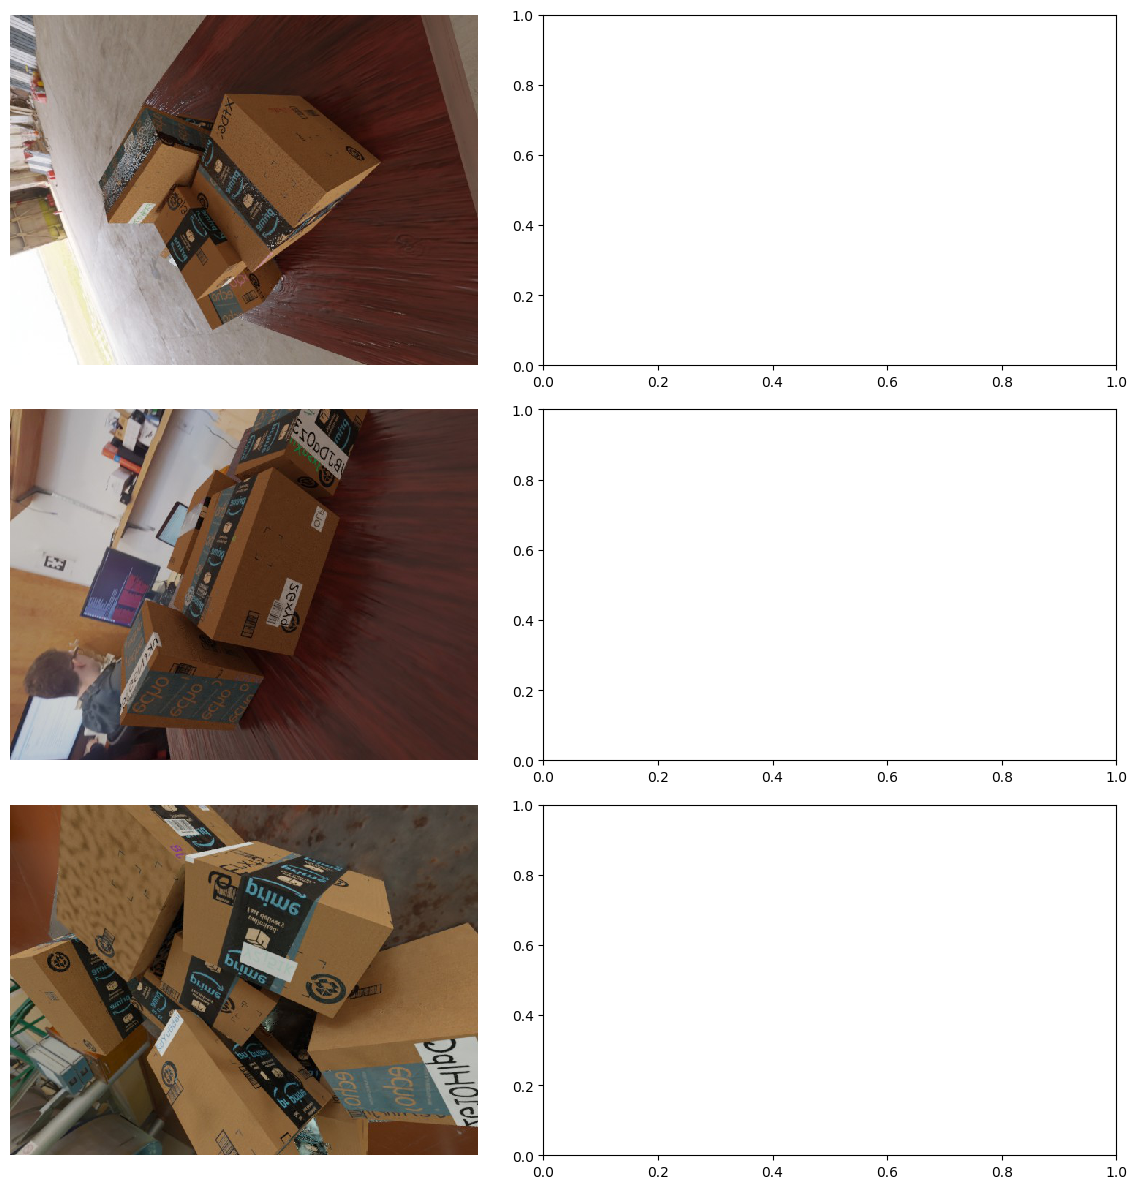

In [7]:
test_cfg = cfg.clone()  # cfg can be modified by model
test_cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
test_cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.9   # set the testing threshold for this model, default was 0.7
test_cfg.DATASETS.TEST = ("synthetic_5_types", )

test_model = build_model(test_cfg)
test_model.eval()
test_metadata = MetadataCatalog.get(test_cfg.DATASETS.TEST[0])

checkpointer = DetectionCheckpointer(test_model)
checkpointer.load(test_cfg.MODEL.WEIGHTS)

height_to_show = 3
plt.figure(dpi=100).set_size_inches(12, 12)
test_loader_iterator = iter(test_loader)
examples = [next(test_loader_iterator)[0] for k in range(height_to_show)]
with torch.no_grad():  # https://github.com/sphinx-doc/sphinx/issues/4258
    #inputs = {"image": image, "height": height, "width": width}
    predictions = test_model(examples)
    for k, pred in enumerate(predictions):
        im = examples[k]["image"].detach().cpu().numpy().transpose([1, 2, 0])*255
        v = Visualizer(
                cv2.cvtColor(im, cv2.COLOR_BGR2RGB),
                metadata=test_metadata, 
                scale=1)
        v = v.draw_instance_predictions(pred["instances"].to("cpu"))
        im_rgb = v.get_image()[:, :, ::-1]
        plt.subplot(height_to_show, 2, 2*k+1)
        cv2_imshow(im_rgb)
        
        plt.subplot(height_to_show, 2, 2*k+2)
        orig_image_gray = rgb2gray(im_rgb.transpose(1, 2, 0))
        num_instances = len(pred["instances"])
        if num_instances > 0:
            total_heatmap = sum([pred["instances"][k].pred_keypoint_heatmap[0, ...]
                                 for k in range(len(pred["instances"]))])
            total_heatmap = resize(total_heatmap.detach().cpu().numpy(), orig_image_gray.shape)
            total_heatmap /= np.max(total_heatmap)
            plt.imshow(np.stack([orig_image_gray*0.75 + total_heatmap*0.25, orig_image_gray*0.75 + total_heatmap*0.25, orig_image_gray*0.75], axis=-1))

plt.tight_layout()